<a href="https://colab.research.google.com/github/pranavrao87/Classification-Models/blob/main/pneumonia_model_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning w/ a Binary Classification Dataset of Pneumonia Chest X-Rays

- Using same [dataset](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fwww.kaggle.com%2Fdatasets%2Fpaultimothymooney%2Fchest-xray-pneumonia ) as before, but this time with transfer learning


In [ ]:
# Upload Kaggle API Token
from google.colab import files
files.upload()

In [2]:
!wget https://raw.githubusercontent.com/pranavrao87/Machine-Learning/main/ML_helper_functions.py

--2023-09-24 04:03:49--  https://raw.githubusercontent.com/pranavrao87/Machine-Learning/main/ML_helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10534 (10K) [text/plain]
Saving to: ‘ML_helper_functions.py’

ML_helper_functions 100%[===================>]  10.29K  --.-KB/s    in 0s      

2023-09-24 04:03:49 (83.9 MB/s) - ‘ML_helper_functions.py’ saved [10534/10534]



In [3]:
from ML_helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [4]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [5]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:31<00:00, 104MB/s] 
100% 2.29G/2.29G [00:31<00:00, 79.0MB/s]


In [6]:
# Get and unpack data
unzip_data("/content/chest-xray-pneumonia.zip")

In [7]:
walk_through_dir("chest_xray")

There are 5 directories and 0 images in 'chest_xray'.
There are 2 directories and 0 images in 'chest_xray/val'.
There are 0 directories and 8 images in 'chest_xray/val/PNEUMONIA'.
There are 0 directories and 8 images in 'chest_xray/val/NORMAL'.
There are 1 directories and 1 images in 'chest_xray/__MACOSX'.
There are 3 directories and 3 images in 'chest_xray/__MACOSX/chest_xray'.
There are 2 directories and 1 images in 'chest_xray/__MACOSX/chest_xray/val'.
There are 0 directories and 9 images in 'chest_xray/__MACOSX/chest_xray/val/PNEUMONIA'.
There are 0 directories and 9 images in 'chest_xray/__MACOSX/chest_xray/val/NORMAL'.
There are 2 directories and 3 images in 'chest_xray/__MACOSX/chest_xray/test'.
There are 0 directories and 390 images in 'chest_xray/__MACOSX/chest_xray/test/PNEUMONIA'.
There are 0 directories and 234 images in 'chest_xray/__MACOSX/chest_xray/test/NORMAL'.
There are 2 directories and 3 images in 'chest_xray/__MACOSX/chest_xray/train'.
There are 0 directories and 3

In [8]:
# Clean up data and delete extra folders
import shutil

shutil.rmtree('/content/chest_xray/__MACOSX', ignore_errors=True)
shutil.rmtree('/content/chest_xray/chest_xray', ignore_errors=True)

In [9]:
walk_through_dir("chest_xray")

There are 3 directories and 0 images in 'chest_xray'.
There are 2 directories and 0 images in 'chest_xray/val'.
There are 0 directories and 8 images in 'chest_xray/val/PNEUMONIA'.
There are 0 directories and 8 images in 'chest_xray/val/NORMAL'.
There are 2 directories and 0 images in 'chest_xray/test'.
There are 0 directories and 390 images in 'chest_xray/test/PNEUMONIA'.
There are 0 directories and 234 images in 'chest_xray/test/NORMAL'.
There are 2 directories and 0 images in 'chest_xray/train'.
There are 0 directories and 3875 images in 'chest_xray/train/PNEUMONIA'.
There are 0 directories and 1341 images in 'chest_xray/train/NORMAL'.


## Visualizing Data

In [10]:
from re import A
# Visualize the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory
  target_folder = target_dir + "/" + target_class

  # Get rand image path
  random_image = random.sample(os.listdir(target_folder), 1) # randomly sample 1 of the items from here
  print(random_image)
  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}") # show shape of image

  return img

In [11]:
# Setting up the train and test directories
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"
val_dir = "chest_xray/val"

In [12]:
# Getting class names (subdirectories)
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted(item.name for item in data_dir.glob('*')))
print(class_names)

['NORMAL' 'PNEUMONIA']


['NORMAL2-IM-0707-0001.jpeg']
Image shape: (1208, 1384)


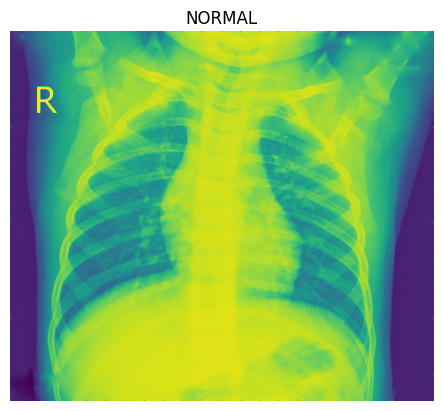

In [13]:
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

## Model 1: EfficientNet - limited data preprocessing and reduced data size

In [15]:
import tensorflow as tf

In [17]:
train_dir = "chest_xray/train"
test_dir = "chest_xray/train"

In [18]:
# 1. Create base model w/ tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
# Not including the top layer b/c we want to add in a different dense
# layer which depends on the number of data inputs

# 2. Freeze base model (so underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using ResNet50V2 need to normalize inputs (not necessary for effecientnet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass inputs to base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of base model (aggregate all most information, reduce num of computations)
# like maxpooling layers
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalaveragePooling2D: {x.shape}")

# 7. Create output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine inputs w/ outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalaveragePooling2D: (None, 1280)
